# Rare Variant eQTLs

I'm going to examine the eQTL results to determine whether any of the eQTLs are driven
by rare variants that are at a higher frequency in our subject set.

In [1]:
import glob
import os
import random
import subprocess

import cdpybio as cpb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import pybedtools as pbt
import seaborn as sns
import statsmodels.stats.multitest as smm
import vcf as pyvcf

import cardipspy as cpy
import ciepy

%matplotlib inline
%load_ext rpy2.ipython

dy_name = 'rare_variant_eqtls'

import socket
if socket.gethostname() == 'fl-hn1' or socket.gethostname() == 'fl-hn2':
    dy = os.path.join(ciepy.root, 'sandbox', 'tmp', dy_name)
    cpy.makedir(dy)
    pbt.set_tempdir(dy)
    
outdir = os.path.join(ciepy.root, 'output', dy_name)
cpy.makedir(outdir)

private_outdir = os.path.join(ciepy.root, 'private_output', dy_name)
cpy.makedir(private_outdir)

In [2]:
fn = os.path.join(ciepy.root, 'output', 'eqtl_processing', 'eqtls01', 'lead_variants.tsv')
lead_vars = pd.read_table(fn, index_col=0)

fn = os.path.join(ciepy.root, 'output', 'eqtl_processing', 'unrelated_eqtls01', 'lead_variants.tsv')
unr_lead_vars = pd.read_table(fn, index_col=0)

fn = os.path.join(ciepy.root, 'output', 'input_data', 'rnaseq_metadata.tsv')
rna_meta = pd.read_table(fn, index_col=0)
rna_meta_eqtl = rna_meta[rna_meta.in_eqtl]

fn = os.path.join(ciepy.root, 'output', 'input_data', 'subject_metadata.tsv')
subject_meta = pd.read_table(fn, index_col=0)

subject_meta_eqtl = subject_meta.ix[rna_meta_eqtl.subject_id]
rna_meta_eqtl = rna_meta_eqtl.merge(subject_meta_eqtl, left_on='subject_id', right_index=True)

In [3]:
lead_vars = lead_vars[lead_vars.perm_sig]
unr_lead_vars = unr_lead_vars[unr_lead_vars.perm_sig]

In [4]:
af_cols = [x for x in lead_vars.columns if '_AF' in x]
lead_vars_af = lead_vars.dropna(subset=af_cols)

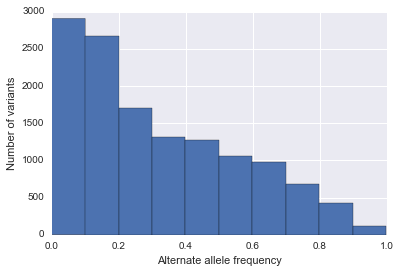

In [5]:
lead_vars_af.AF.hist()
plt.ylabel('Number of variants')
plt.xlabel('Alternate allele frequency');

The allele frequencies from 1,000 Genomes are for the alternate allele, 
so I need to take care when I define which allele is minor.

In [6]:
a = sum((lead_vars_af[af_cols] < 0.005).sum(axis=1) == len(af_cols))
b = sum((lead_vars_af[af_cols] > 1 - 0.005).sum(axis=1) == len(af_cols))
print('There are {} variants where the alternate is rare and {} '
      'where the reference is rare.'.format(a, b))

There are 143 variants where the alternate is rare and 0 where the reference is rare.


It doesn't seem like any of my eQTL lead variants have rare reference alleles, so I can 
say that rare variants have the alternate allele as the minor allele.

In [7]:
lead_vars_af['rare'] = False
lead_vars_af.ix[lead_vars_af[(lead_vars_af[af_cols] < 0.005).sum(axis=1) == len(af_cols)].index, 'rare'] = True
a = lead_vars_af.rare.sum()
b = len(set(lead_vars_af.ix[lead_vars_af.rare, 'gene_id']))
print('There are {} rare lead variants for {} eGenes.'.format(a, b))

There are 143 rare lead variants for 106 eGenes.


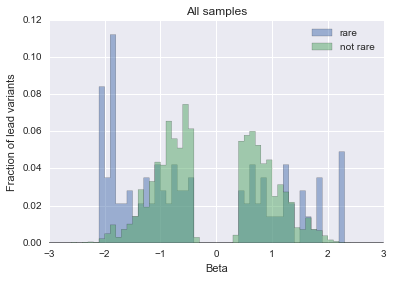

In [9]:
se = lead_vars_af[lead_vars_af.rare].beta
weights = np.ones_like(se) / float(se.shape[0])
se.hist(bins=np.arange(-3, 3.1, 0.1), label='rare', alpha=0.5, weights=weights, histtype='stepfilled')

se = lead_vars_af[lead_vars_af.rare == False].beta
weights = np.ones_like(se) / float(se.shape[0])
se.hist(bins=np.arange(-3, 3.1, 0.1), label='not rare', alpha=0.5, weights=weights, histtype='stepfilled')
plt.xlim(-3, 3)
plt.xlabel('Beta')
plt.ylabel('Fraction of lead variants')
plt.title('All samples')
plt.legend();

In [10]:
af_cols = [x for x in unr_lead_vars.columns if '_AF' in x]
unr_lead_vars_af = unr_lead_vars.dropna(subset=af_cols)
unr_lead_vars_af['rare'] = False
unr_lead_vars_af.ix[unr_lead_vars_af[(unr_lead_vars_af[af_cols] < 0.005).sum(axis=1) == 
                                     len(af_cols)].index, 'rare'] = True

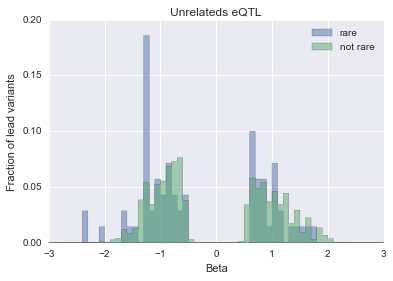

In [11]:
se = unr_lead_vars_af[unr_lead_vars_af.rare].beta
weights = np.ones_like(se) / float(se.shape[0])
se.hist(bins=np.arange(-3, 3.1, 0.1), label='rare', alpha=0.5, weights=weights, histtype='stepfilled')

se = unr_lead_vars_af[unr_lead_vars_af.rare == False].beta
weights = np.ones_like(se) / float(se.shape[0])
se.hist(bins=np.arange(-3, 3.1, 0.1), label='not rare', alpha=0.5, weights=weights, histtype='stepfilled')
plt.xlim(-3, 3)
plt.xlabel('Beta')
plt.ylabel('Fraction of lead variants')
plt.title('Unrelateds eQTL')
plt.legend();

In [12]:
out = os.path.join(private_outdir, 'genotypes.tsv')
if not os.path.exists(out):
    genotypes = pd.DataFrame(np.nan, index=lead_vars_af.index, columns=rna_meta_eqtl.wgs_id)

    fn = '/projects/CARDIPS/analysis/cardips-ipsc-eqtl/private_output/eqtl_input/filtered_all/0000.vcf.gz'
    vcf_reader = pyvcf.VCFReader(open(fn))

    count = 0
    for i in lead_vars_af.index:
        if count % 1000 == 0:
            print(count)
        res = vcf_reader.fetch(lead_vars_af.ix[i, 'chrom'][3:], lead_vars_af.ix[i, 'end'],
                               lead_vars_af.ix[i, 'end'])
        r = res.next()

        hom_refs = set(rna_meta_eqtl.wgs_id) & set([x.sample for x in r.get_hom_refs()])
        hets = set(rna_meta_eqtl.wgs_id) & set([x.sample for x in r.get_hets()])
        hom_alts = set(rna_meta_eqtl.wgs_id) & set([x.sample for x in r.get_hom_alts()])

        genotypes.ix[i, hom_refs] = 0
        genotypes.ix[i, hets] = 1
        genotypes.ix[i, hom_alts] = 2
        count += 1

    genotypes.to_csv(out, sep='\t')
else:
    genotypes = pd.read_table(out, index_col=0)

In [13]:
genotypes_f = genotypes.ix[lead_vars_af.index, rna_meta_eqtl.wgs_id]

In [14]:
lead_vars_af['ref_is_major'] = lead_vars_af.ac < lead_vars_af.ns

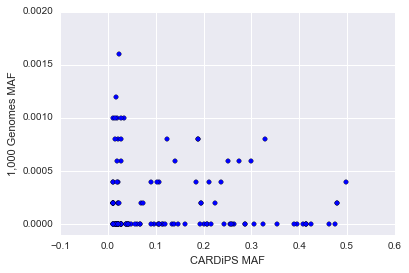

In [15]:
t = lead_vars_af[lead_vars_af.rare]
plt.scatter(t.maf, t.AF)
plt.ylim(-0.0001, 0.002)
plt.ylabel('1,000 Genomes MAF')
plt.xlabel('CARDiPS MAF');

In [16]:
family_vc = subject_meta_eqtl.family_id.value_counts()
family_vc = family_vc[family_vc * 2 >= lead_vars_af.ac.min()]

In [17]:
for i in family_vc.index:
    se = genotypes_f[rna_meta_eqtl[rna_meta_eqtl.family_id == i].wgs_id].sum(axis=1)
    c = '{}_maf'.format(i)
    lead_vars_af[c] = np.nan
    lead_vars_af.ix[lead_vars_af.ref_is_major, c] = se[lead_vars_af.ref_is_major] / (family_vc[i] * 2)
    lead_vars_af.ix[lead_vars_af.ref_is_major == False, c] = \
        (family_vc[i] * 2 - se[lead_vars_af.ref_is_major == False]) / (family_vc[i] * 2)
    c = '{}_mac'.format(i)
    lead_vars_af.ix[lead_vars_af.ref_is_major, c] = se[lead_vars_af.ref_is_major]
    lead_vars_af.ix[lead_vars_af.ref_is_major == False, c] = \
        (family_vc[i] * 2 - se[lead_vars_af.ref_is_major == False])

In [18]:
c = '{}_maf'.format(family_vc.index[1])
t = lead_vars_af[lead_vars_af[c] > lead_vars_af.maf]
t = t[t.rare]
t = t[t.maf < 0.05]

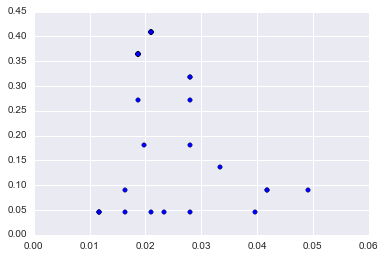

In [19]:
plt.scatter(t.maf, t[c])

In [34]:
for i in family_vc.index:
    c = '{}_mac'.format(i)
    a = set(subject_meta.ix[subject_meta.family_id == i, 'ethnicity_group'])
    print(i, len(set(lead_vars_af.ix[lead_vars_af.ac == lead_vars_af[c], 'gene_id'])), list(a))

('abb401f1-5c3e-48ed-8c55-839ce2afe7e6', 1, ['Hispanic', 'African American', 'Multiple ethnicities reported', 'European'])
('84fda65d-9a06-4bbe-ad75-a24773724c32', 2, ['Asian', 'Multiple ethnicities reported', 'European'])
('a56f620d-82e4-4963-a80b-b97c091c4b06', 0, ['Multiple ethnicities reported', 'European'])
('319aca18-4ca4-444d-80ca-3c0065169793', 0, ['Asian'])
('0a78a1f4-540f-4f63-acd1-197228abad11', 0, ['European'])
('cec0061a-f86c-4d8f-979f-3c6edce2d905', 0, ['European'])
('24bb1db3-75fb-4c66-9ccd-8e98dc3fadf1', 0, ['European'])
('f9d0c0e4-4408-469a-8c14-e65352142cc9', 0, ['Asian'])
('225e50a6-3386-4df5-b47d-6a564cde04d3', 0, ['Asian'])
('a23bb99f-656b-4853-a029-2400ec16dae6', 0, ['European'])
('2c54a579-6ba4-45be-b3cc-e2003349acd7', 0, ['European'])
('0fef459e-1c58-4bf8-9b2e-48da79a78536', 0, ['European'])
('bdc08658-e9d6-45ce-8f51-57775682c800', 0, ['European'])
('25e71a57-1993-4844-a0e1-f273522a8d05', 0, ['European'])
('bdc7cf80-9790-410e-abf0-6085d2881790', 0, ['European'])

In [21]:
subject_meta[subject_meta.family_id == '84fda65d-9a06-4bbe-ad75-a24773724c32'].head()

,sex,age,family_id,father_id,mother_id,twin_id,ethnicity_group
id,,,,,,,
f549b5fa-a6c0-49fb-8a07-dda4f72ff076,M,51.9,84fda65d-9a06-4bbe-ad75-a24773724c32,NaN,NaN,NaN,European
2a81d225-42f6-43cf-904a-be64bf3fd2d7,F,45.2,84fda65d-9a06-4bbe-ad75-a24773724c32,6a784dd7-9c48-4841-93f9-930b9de49cc4,ae3637d4-493e-482e-bc48-6915e30ffb9c,NaN,Multiple ethnicities reported
e932e556-59a6-4f70-9b4c-ef5f69dac3ce,F,48.3,84fda65d-9a06-4bbe-ad75-a24773724c32,6a784dd7-9c48-4841-93f9-930b9de49cc4,ae3637d4-493e-482e-bc48-6915e30ffb9c,NaN,Multiple ethnicities reported
de9c74e8-d399-465e-92cd-904a0e323bca,M,50.2,84fda65d-9a06-4bbe-ad75-a24773724c32,6a784dd7-9c48-4841-93f9-930b9de49cc4,ae3637d4-493e-482e-bc48-6915e30ffb9c,NaN,European
f772212a-cd98-40f9-bdcd-e75740c1f6be,F,18.1,84fda65d-9a06-4bbe-ad75-a24773724c32,f549b5fa-a6c0-49fb-8a07-dda4f72ff076,e932e556-59a6-4f70-9b4c-ef5f69dac3ce,NaN,European


In [21]:
lead_vars_af.to_csv(os.path.join(outdir, 'lead_vars_af.tsv'), sep='\t')
unr_lead_vars_af.to_csv(os.path.join(outdir, 'unr_lead_vars_af.tsv'), sep='\t')

In [28]:
tdf = lead_vars_af[lead_vars_af.rare]

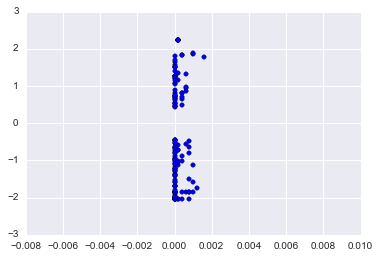

In [31]:
plt.scatter(tdf.AF, tdf.beta)

In [35]:
t = lead_vars_af[lead_vars_af.ac == lead_vars_af['84fda65d-9a06-4bbe-ad75-a24773724c32_mac']]
t.sort_values(by='pvalue', inplace=True)
t.drop_duplicates(subset=['gene_id'])

,chrom,start,end,marker_id,ns,ac,callrate,genocnt,maf,stat,...,d4bfdb4d-593c-4216-8a85-85bc98ec8f50_maf,d4bfdb4d-593c-4216-8a85-85bc98ec8f50_mac,6c5edc7b-4dde-4802-80e7-995b62133292_maf,6c5edc7b-4dde-4802-80e7-995b62133292_mac,530532cb-78cc-41e8-a2bc-a30e9108221b_maf,530532cb-78cc-41e8-a2bc-a30e9108221b_mac,80d4fbb6-6aaf-4414-acf9-e75d02ba15a6_maf,80d4fbb6-6aaf-4414-acf9-e75d02ba15a6_mac,f5352d65-a24e-4d0c-84a8-0539e396a5e4_maf,f5352d65-a24e-4d0c-84a8-0539e396a5e4_mac
chr14:23615514-23615515:ENSG00000100897.13,chr14,23615514,23615515,14:23615515_G/A_rs117617634,215,9,1,206/9/0,0.02093,-4.8404,...,0,0,0,0,0,0,0,0,0,0
chr11:66914128-66914129:ENSG00000173992.4,chr11,66914128,66914129,11:66914129_A/G,215,8,1,207/8/0,0.01860,-4.4335,...,0,0,0,0,0,0,0,0,0,0


In [36]:
t = lead_vars_af[lead_vars_af.ac == lead_vars_af['abb401f1-5c3e-48ed-8c55-839ce2afe7e6_mac']]
t.sort_values(by='pvalue', inplace=True)
t.drop_duplicates(subset=['gene_id'])

,chrom,start,end,marker_id,ns,ac,callrate,genocnt,maf,stat,...,d4bfdb4d-593c-4216-8a85-85bc98ec8f50_maf,d4bfdb4d-593c-4216-8a85-85bc98ec8f50_mac,6c5edc7b-4dde-4802-80e7-995b62133292_maf,6c5edc7b-4dde-4802-80e7-995b62133292_mac,530532cb-78cc-41e8-a2bc-a30e9108221b_maf,530532cb-78cc-41e8-a2bc-a30e9108221b_mac,80d4fbb6-6aaf-4414-acf9-e75d02ba15a6_maf,80d4fbb6-6aaf-4414-acf9-e75d02ba15a6_mac,f5352d65-a24e-4d0c-84a8-0539e396a5e4_maf,f5352d65-a24e-4d0c-84a8-0539e396a5e4_mac
chr7:111481507-111481508:ENSG00000006652.9,chr7,111481507,111481508,7:111481508_C/T,215,6,1,209/6/0,0.01395,4.374,...,0,0,0,0,0,0,0,0,0,0


TODO: Are any of the lead variants for the second or third eQTLs rare?